# **Quantum Spy Hunter**

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister, execute, BasicAer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
import math
%matplotlib inline

In [3]:
# Set up the program
alice = QuantumRegister(1, name='alice')
fiber = QuantumRegister(1, name='fiber')
bob   = QuantumRegister(1, name='bob')
alice_had = ClassicalRegister(1, name='ahad')
alice_val = ClassicalRegister(1, name='aval')
fiber_val = ClassicalRegister(1, name='fval')
bob_had   = ClassicalRegister(1, name='bhad')
bob_val   = ClassicalRegister(1, name='bval')
qc = QuantumCircuit(alice, fiber, bob, alice_had, alice_val, fiber_val, bob_had, bob_val)

In [4]:
# Use Alice's QPU to generate two random bits
qc.reset(alice)          # write the value 0
qc.h(alice)
qc.measure(alice, alice_had)
qc.reset(alice)          # write the value 0
qc.h(alice)
qc.measure(alice, alice_val)

In [5]:
# Prepare Alice's qubit
qc.reset(alice)          # write the value 0
qc.x(alice).c_if(alice_val, 1)
qc.h(alice).c_if(alice_had, 1)

In [6]:
# Send the qubit!
qc.swap(alice, fiber)

In [7]:
# Activate the spy
spy_is_present = True
if spy_is_present:
    qc.barrier()
    spy_had = True
    if spy_had:
        qc.h(fiber)
    qc.measure(fiber, fiber_val)
    qc.reset(fiber)
    qc.x(fiber).c_if(fiber_val, 1)
    if spy_had:
        qc.h(fiber)

qc.barrier()

In [8]:
# Use Bob's QPU to generate a random bit
qc.reset(bob)
qc.h(bob)
qc.measure(bob, bob_had)

In [9]:
# Receive the qubit!
qc.swap(fiber, bob)
qc.h(bob).c_if(bob_had, 1)
qc.measure(bob, bob_val)

backend = BasicAer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()

counts: {'1 1 1 1 1': 1}
No spies detected.
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.-0.j 0.+0.j]


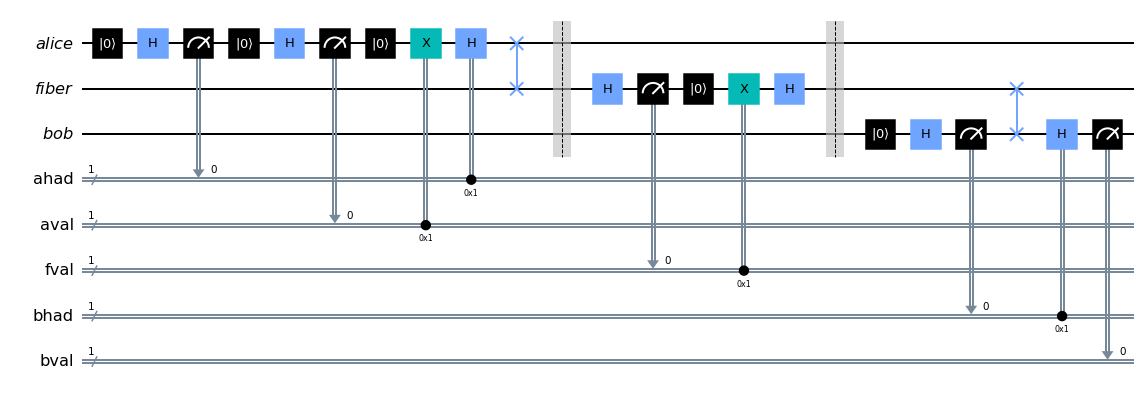

In [10]:
# Now Alice emails Bob to tell
# him her had setting and value.
# If the had setting matches and the
# value does not, there's a spy!
counts = result.get_counts(qc)
print('counts:',counts)
caught = False
for key,val in counts.items():
    ahad,aval,f,bhad,bval = (int(x) for x in key.split(' '))
    if ahad == bhad:
        if aval != bval:
            print('Caught a spy!')
            caught = True
if not caught:
    print('No spies detected.')

outputstate = result.get_statevector(qc, decimals=3)
print(outputstate)
qc.draw()        # draw the circuit